In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
# set tf to cpu only
tf.config.set_visible_devices([], 'GPU')
import jax
jax.config.update('jax_platform_name', 'cpu')
from typing import Any
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader
from mtr.config import cfg, cfg_from_yaml_file
from bc.behavior_cloning import BehaviorCloning
from bc.bc_dataset import BCDataset
from rl_env.env_utils import inverse_unicycle_control,smooth_scenario
torch.set_float32_matmul_precision('high')

/home/zixuzhang/mambaforge/envs/waymax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# fake dataset
from waymax import config as _config
from waymax import visualization
from rl_env.waymax_util import WomdLoader
from rl_env.env_utils import merge_dict, process_input
import mediapy

WOMD_1_2_0_VAL_LOCAL = _config.DatasetConfig(
    # path='/Data/Dataset/Waymo/V1_2_tf/validation_interactive/validation_interactive_tfexample.tfrecord@150',
    path='/Data/Dataset/Waymo/V1_2_tf/validation/validation_tfexample.tfrecord@150',
    # path='/Data/Dataset/Waymo/V1_2_tf/training/training_tfexample.tfrecord@1000',
    max_num_rg_points=30000,
    data_format=_config.DataFormat.TFRECORD,
    max_num_objects=32,
    shuffle_seed = 99,
)
data_iter = WomdLoader(data_config=WOMD_1_2_0_VAL_LOCAL)

# Test with Discrete

In [4]:
# cfg_file = 'tools/cfgs/waymo/bc_atten_discrete.yaml'
# cfg_from_yaml_file(cfg_file, cfg)
model_path = 'output/bc_discrete_4_freeze/epoch=0-step=300000.ckpt'

BC = BehaviorCloning.load_from_checkpoint(model_path, map_location='cpu')
_ = BC.to('cuda')
_ = BC.eval()
BC.decoder.pred_all_layers = False

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


""

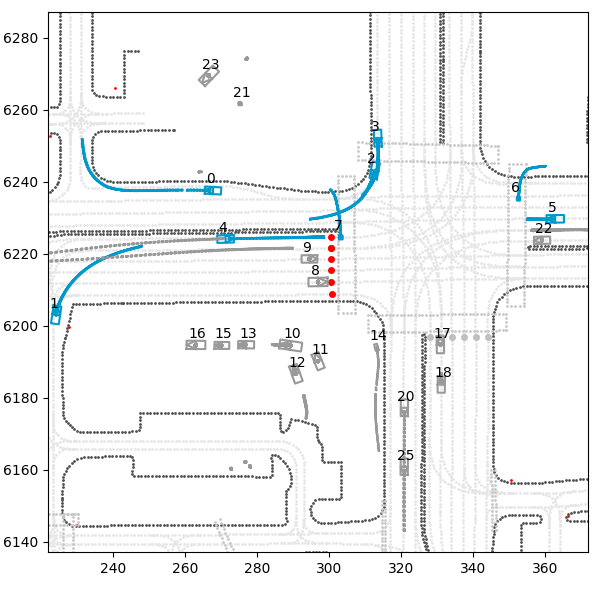

In [5]:
scenario_id, scenario = data_iter.next()
scenario = smooth_scenario(scenario)
img = visualization.plot_simulator_state(scenario, use_log_traj=True, highlight_obj = _config.ObjectType.MODELED)
mediapy.show_image(img)

In [8]:
num_agent = len(scenario.object_metadata.is_sdc)
is_ctrl = np.zeros(num_agent, dtype=bool)
a = 0
is_ctrl[a] = True
t= 0

13
tensor([[-2.5440,  0.0264]], device='cuda:0')
Sample {'sample': tensor([[1.5000, 0.0500]], device='cuda:0'), 'log_p': tensor([-1.2338], device='cuda:0')}
best tensor(22.8351, device='cuda:0')
{'loss_d0_h0': 5.5578813552856445, 'loss_d0_h1': 10.80617618560791, 'loss_d0_h2': 10.86816692352295, 'loss_d0_entropy': 0.1271783411502838, 'loss_total': 22.835119247436523}


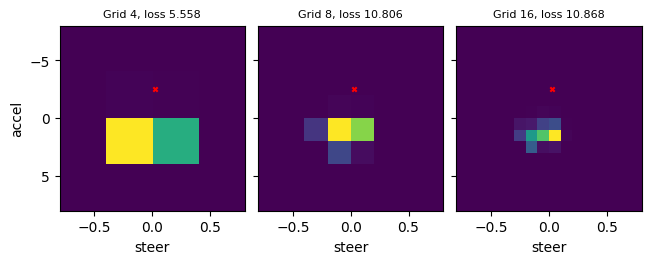

In [22]:
print(t)
input = process_input(
    scenario,
    is_ctrl,
    from_gt=True,
    current_time_index=t,
    hide_history=1
    )

gt_action, action_valid = inverse_unicycle_control(scenario)

# gt_action = np.asarray(
# compute_inverse(scenario.log_trajectory, t, estimate_yaw_with_velocity=True).data[is_ctrl]
# )
input['gt_action'] = gt_action[a, t:t+1]
batch = merge_dict([input], 'cuda')

BC.zero_grad()
with torch.no_grad():
    encoder_output = BC.encoder(batch, retain_input=True)
    decoder_output = BC.decoder(encoder_output)
    total_loss_best, tb_dict_best = BC.decoder.get_loss(decoder_output, debug = True)

print('Sample', BC.decoder.sample(decoder_output, True))

print('best', total_loss_best)
print(tb_dict_best)

t += 1

# Test with Control



In [4]:
cfg_file = 'tools/cfgs/waymo/bc_atten_ctrl.yaml'
cfg_from_yaml_file(cfg_file, cfg)

model_path = 'output/bc_bicycle_4_freeze/epoch=0-step=755000.ckpt'

BC = BehaviorCloning.load_from_checkpoint(model_path, map_location='cpu')
_ = BC.to('cuda')
_ = BC.eval()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


""

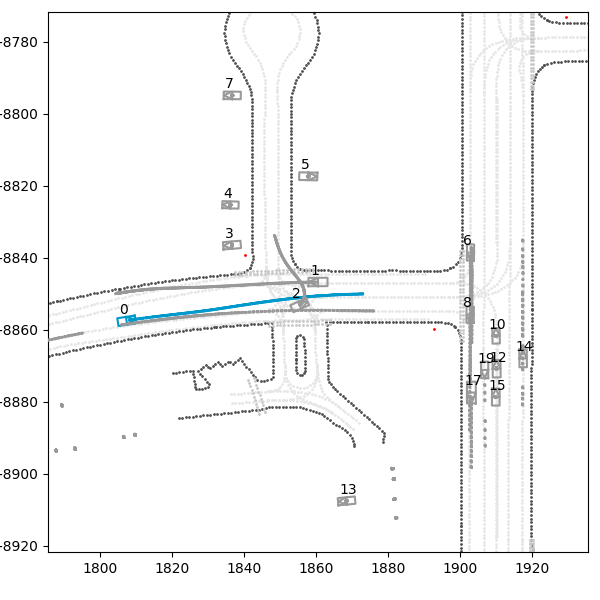

In [5]:
scenario_id, scenario = data_iter.next()
img = visualization.plot_simulator_state(scenario, use_log_traj=True, highlight_obj = _config.ObjectType.MODELED)
mediapy.show_image(img)

In [6]:
smoothed_scenario = smooth_scenario(scenario, duplicate=True)
gt_action, gt_valid = inverse_unicycle_control(smoothed_scenario)

In [7]:
num_agent = len(scenario.object_metadata.is_sdc)
is_ctrl = np.zeros(num_agent, dtype=bool)
a = 0
is_ctrl[a] = True
t= 1

In [62]:
input = process_input(
    smoothed_scenario,
    is_ctrl,
    from_gt=True,
    current_time_index=t,
    hide_history=1
)
input['gt_action'] = gt_action[a, t:t+1]
batch = merge_dict([input], 'cuda')

BC.zero_grad()
with torch.no_grad():
    encoder_output = BC.encoder(batch, retain_input=True)
    decoder_output = BC.decoder(encoder_output)
    total_loss_best, tb_dict_best = BC.decoder.get_loss_best(decoder_output, debug = True)
    # build GMM
    (pred_states, pred_scores) = decoder_output['pred_list'][-1]
    mode, mix, gmm = BC.decoder.build_gmm_distribution(pred_states, pred_scores, log_std_range = (-5, 2))
    
A_scale = np.diag(BC.decoder.output_std.cpu().detach().numpy())
    
print('Sample', BC.decoder.sample(decoder_output, False))

print('best', total_loss_best)
print(tb_dict_best)

unnormalized tensor([ 0.3570, -0.0082], device='cuda:0') normalized tensor([ 0.1522, -0.1796], device='cuda:0')
Prediction tensor([[[-7.7548e-01,  1.0787e+00,  1.2247e-01, -5.8750e-01, -1.1579e-01],
         [-1.3883e+00,  8.6010e-01, -1.2515e+00, -1.0020e+00,  1.0859e-01],
         [-1.0453e-01,  5.1713e-01, -1.0874e+00, -8.0166e-01, -1.3672e-03],
         [ 9.2117e-01,  3.1703e-01, -9.0971e-01, -1.0205e+00, -5.2591e-02],
         [-8.2161e-01,  6.6804e-01, -1.1612e+00, -7.9377e-01,  5.3850e-02],
         [-1.8976e+00,  9.6330e-01, -9.4424e-01, -1.0537e+00,  8.2066e-02]]],
       device='cuda:0')
nll tensor([[ 4.0878, 19.9848,  1.4433,  2.8256,  6.8096, 20.6535]],
       device='cuda:0')
score tensor([2], device='cuda:0') tensor([[ 0.6506,  0.1169,  0.1143, -0.3007,  0.2926, -0.0862]],
       device='cuda:0')
Sample {'sample': tensor([[-1.0738,  0.1770]], device='cuda:0'), 'log_prob': tensor([-1.5254], device='cuda:0')}
best tensor(2.5822, device='cuda:0')
{'layer0_loss_l1': 0.9534440

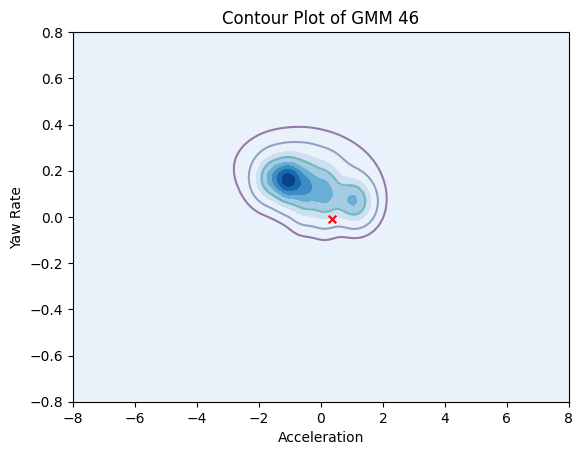

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

weights = mix.probs[0].cpu().detach().numpy()
# weights = np.ones((6,))/6
means = mode.loc[0].cpu().detach().numpy()
covariances = mode.covariance_matrix[0].cpu().detach().numpy()

means = means@A_scale + BC.decoder.output_mean.cpu().detach().numpy()
covariances = A_scale@covariances@A_scale

# Generate a grid of points to evaluate the contour
x = np.linspace(-8, 8, 100)
y = np.linspace(-0.8, 0.8, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Evaluate the PDF (probability density function) of the SciPy GMM at each point
Z = np.zeros_like(X)
for i in range(len(weights)):
    # Z += weights[i]*multivariate_normal.pdf(pos, mean=means[i], cov=covariances[i])
    Z += multivariate_normal.pdf(pos, mean=means[i], cov=covariances[i])

# Plot the contour
CS = plt.contour(X, Y, np.log(Z), levels = np.linspace(-2, 5, 5), alpha = 0.5)
CSF = plt.contourf(X, Y, Z+1e-5, cmap = plt.cm.Blues)
# plt.gca().clabel(CS, CS.levels, inline=True, fontsize=10)
plt.scatter(gt_action[a, t, 0], gt_action[a, t, 1], c='r', s=30, marker='x')
# plt.colorbar(CSF)
plt.xlabel('Acceleration')
plt.ylabel('Yaw Rate')
plt.title(f'Contour Plot of GMM {t}')
plt.show()

t+=5